In [2]:
#Import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
#Initialize the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [4]:
#Store the images and the categories
DIRECTORY = r"C:\Users\hp\Downloads\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
#Store the images as a list in data and the corresponding category in labels list
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

C:\Users\hp\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [6]:
#Convert the label string values into numeric by performing one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
#Convert the data and labels list into arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
#Train test split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [9]:
#Construct the training image generator for data augmentation since the dataset is small
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [10]:
#Load MobileNetV2 network base model
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\hp\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 12s 1us/step


In [11]:
#Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
#Construct the final model with the head model on the top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
#Loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
#Compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [15]:
#Train the head of the network
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
95/95 [==============================] - 1377s 14s/step - loss: 0.5508 - acc: 0.7297 - val_loss: 0.4691 - val_acc: 0.7640
Epoch 2/20
95/95 [==============================] - 1353s 14s/step - loss: 0.3026 - acc: 0.8810 - val_loss: 0.4522 - val_acc: 0.7966
Epoch 3/20
95/95 [==============================] - 911s 10s/step - loss: 0.2152 - acc: 0.9216 - val_loss: 0.3054 - val_acc: 0.8722
Epoch 4/20
95/95 [==============================] - 808s 9s/step - loss: 0.1869 - acc: 0.9321 - val_loss: 0.4054 - val_acc: 0.8409
Epoch 5/20
95/95 [==============================] - 787s 8s/step - loss: 0.1786 - acc: 0.9347 - val_loss: 0.2799 - val_acc: 0.8840
Epoch 6/20
95/95 [==============================] - 798s 8s/step - loss: 0.1581 - acc: 0.9367 - val_loss: 0.2565 - val_acc: 0.8879
Epoch 7/20
95/95 [==============================] - 791s 8s/step - loss: 0.1468 - acc: 0.9473 - val_loss: 0.3043 - 

In [20]:
#Make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

In [21]:
#Serialize the model to disk
model.save("mask_detector.model", save_format="h5")

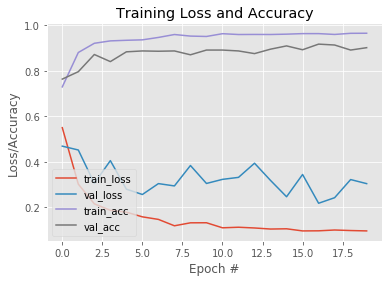

In [24]:
#Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")